## Sebelum membaca ini, baca dulu merl-shopping-train.ipynb

Jadi, ini sama kayak notebook sebelumnya, perbedaannya pada ngetrain. ini aku fine tune dengan datasetku sdeniri (kurekam sendiri). totalnya cuma 50 an video, jadi keanya ngga terlalu perngaruh. Tapi buat nambah2 aja, videonya yaa tak rekam pake webcam dengan posisi agak di ujung gitu deh, mirip cctv ala2.

Karena datasetnya kecil, yaa hasil testnya kurang bisa merepresentasika secara statistik, lihat output, tapi yooo dah mayan jane. 

In [1]:
!pip install --upgrade -q "transformers[torch]" accelerate datasets evaluate decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 9.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 89.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import nn
from transformers import AutoImageProcessor, AutoModelForVideoClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from huggingface_hub import snapshot_download
import evaluate
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from decord import VideoReader, cpu

2025-07-02 17:51:09.275699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751478669.490452      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751478669.553822      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
NEW_DATASET_REPO_ID = "haipradana/action" 

WORK_DIR = "/kaggle/working"
DATASET_DIR = os.path.join(WORK_DIR, "CCTV_Shopping_Dataset")

print(f"Downloading new CCTV dataset from: {NEW_DATASET_REPO_ID}")
snapshot_download(
    repo_id=NEW_DATASET_REPO_ID,
    repo_type="dataset",
    local_dir=DATASET_DIR
)
print("Dataset baru berhasil diunduh.")

VIDEOS_DIR = os.path.join(DATASET_DIR, "videos")
LABELS_DIR = os.path.join(DATASET_DIR, "labels")

Fetching 105 files:   0%|          | 0/105 [00:00<?, ?it/s]

0_6_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_3_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_2_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_1_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

0_5_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_7_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_4_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

1_1_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

1_2_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_4_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

3_8_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_1_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_5_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_6_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_8_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_9_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_3_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

4_7_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_4_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_2_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_5_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_1_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_7_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_6_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

5_8_label.mat:   0%|          | 0.00/528 [00:00<?, ?B/s]

0_1.mp4:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

0_4.mp4:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

0_3.mp4:   0%|          | 0.00/7.02M [00:00<?, ?B/s]

0_2.mp4:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

0_5.mp4:   0%|          | 0.00/4.66M [00:00<?, ?B/s]

0_6.mp4:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

1_1.mp4:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

0_7.mp4:   0%|          | 0.00/6.57M [00:00<?, ?B/s]

1_2.mp4:   0%|          | 0.00/4.30M [00:00<?, ?B/s]

1_3.mp4:   0%|          | 0.00/3.88M [00:00<?, ?B/s]

1_4.mp4:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

1_5.mp4:   0%|          | 0.00/2.58M [00:00<?, ?B/s]

1_6.mp4:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

1_7.mp4:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

1_8.mp4:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

1_9.mp4:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

2_1.mp4:   0%|          | 0.00/5.50M [00:00<?, ?B/s]

2_5.mp4:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

2_6.mp4:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

2_7.mp4:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

2_2.mp4:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

2_4.mp4:   0%|          | 0.00/3.43M [00:00<?, ?B/s]

2_3.mp4:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

2_8.mp4:   0%|          | 0.00/2.90M [00:00<?, ?B/s]

2_9.mp4:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

3_10.mp4:   0%|          | 0.00/6.31M [00:00<?, ?B/s]

3_2.mp4:   0%|          | 0.00/4.57M [00:00<?, ?B/s]

3_1.mp4:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

3_3.mp4:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

3_4.mp4:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

3_8.mp4:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

3_9.mp4:   0%|          | 0.00/4.54M [00:00<?, ?B/s]

4_2.mp4:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

4_1.mp4:   0%|          | 0.00/8.29M [00:00<?, ?B/s]

4_5.mp4:   0%|          | 0.00/4.20M [00:00<?, ?B/s]

4_3.mp4:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

4_4.mp4:   0%|          | 0.00/5.72M [00:00<?, ?B/s]

4_6.mp4:   0%|          | 0.00/8.14M [00:00<?, ?B/s]

4_7.mp4:   0%|          | 0.00/8.53M [00:00<?, ?B/s]

4_8.mp4:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

4_9.mp4:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

5_2.mp4:   0%|          | 0.00/7.63M [00:00<?, ?B/s]

5_1.mp4:   0%|          | 0.00/7.33M [00:00<?, ?B/s]

5_3.mp4:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

5_4.mp4:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

5_5.mp4:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

5_6.mp4:   0%|          | 0.00/1.88M [00:00<?, ?B/s]

5_7.mp4:   0%|          | 0.00/6.09M [00:00<?, ?B/s]

5_8.mp4:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

Dataset baru berhasil diunduh.


In [4]:
import pandas as pd
import glob
import re
from scipy.io import loadmat
import numpy as np

# Pertahankan fungsi load_mat_labels Anda
def load_mat_labels(label_path):
    try:
        mat_data = loadmat(label_path)
        if 'tlabs' in mat_data: return mat_data['tlabs']
        data_keys = [k for k in mat_data.keys() if not k.startswith('__')]
        if data_keys: return mat_data[data_keys[0]]
        return None
    except Exception as e:
        print(f"Error loading {label_path}: {e}")
        return None

# Fungsi baru untuk membuat DataFrame berisi informasi klip
def create_clips_dataframe(videos_dir, labels_dir):
    all_clips_data = []
    video_paths = sorted(glob.glob(os.path.join(videos_dir, "*.mp4")))
    
    # Kita butuh FPS untuk konversi frame nanti. Asumsikan 30 FPS.
    # Jika berbeda, decord akan membacanya nanti.
    fps_skip = 2 # Dari 30fps di video asli ke 15fps target 

    for video_path in video_paths:
        match = re.search(r'(\d+)_(\d+)\.mp4', os.path.basename(video_path))
        if not match: continue
        
        base_id, sub_id = match.groups()
        video_id_str = f"{base_id}_{sub_id}"
        
        label_path = os.path.join(labels_dir, f"{video_id_str}_label.mat")
        if not os.path.exists(label_path): continue

        labels_data = load_mat_labels(label_path)
        if labels_data is None: continue

        # Logika Anda untuk membuat interval aksi dari .mat
        action_intervals = []
        for class_idx, class_actions in enumerate(labels_data):
            if len(class_actions[0]) > 0:
                for start_frame, end_frame in class_actions[0]:
                    action_intervals.append({
                        'start': int(start_frame) - 1, # 0-based
                        'end': int(end_frame) - 1,   # 0-based
                        'class': class_idx # 1-5
                    })
        action_intervals.sort(key=lambda x: x['start'])

        # Logika Anda untuk membuat klip, termasuk kelas BACKGROUND
        current_frame = 0
        video_total_frames = 10000 # Placeholder, akan dibaca decord nanti
        
        for interval in action_intervals:
            if current_frame < interval['start']:
                all_clips_data.append({
                    'video_id': video_id_str,
                    'start_frame': current_frame,
                    'end_frame': interval['start'] - 1,
                    'class': 0 # Background
                })
            
            all_clips_data.append({
                'video_id': video_id_str,
                'start_frame': interval['start'],
                'end_frame': interval['end'],
                'class': interval['class']
            })
            current_frame = interval['end'] + 1
        
        # Sisa klip background di akhir
        # Kita tidak perlu ini sekarang, biarkan Dataset yang mengaturnya nanti
    
    return pd.DataFrame(all_clips_data)

# Buat DataFrame utama
print("Creating master DataFrame from labels...")
combined_df = create_clips_dataframe(VIDEOS_DIR, LABELS_DIR)

# Hapus klip yang terlalu pendek
min_clip_length = 8 # Minimal 8 frame @30fps, atau ~0.25 detik
combined_df['duration'] = combined_df['end_frame'] - combined_df['start_frame']
combined_df = combined_df[combined_df['duration'] >= min_clip_length].reset_index(drop=True)

print(f"DataFrame created with {len(combined_df)} clips.")
print("\nClass Distribution:")
print(combined_df['class'].value_counts().sort_index())
combined_df.head()

Creating master DataFrame from labels...
DataFrame created with 52 clips.

Class Distribution:
class
0     7
1     9
2     9
3    10
4     9
5     8
Name: count, dtype: int64


,video_id,start_frame,end_frame,class,duration
0,0_1,0,171,0,171
1,0_2,0,86,0,86
2,0_3,0,166,0,166
3,0_4,0,114,0,114
4,0_5,0,109,0,109


In [5]:
from sklearn.model_selection import train_test_split

# Split data 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(
    combined_df,
    test_size=0.3,
    stratify=combined_df['class'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class'],
    random_state=42
)

print(f"Data split successfully:")
print(f"  Training set:   {len(train_df)} clips")
print(f"  Validation set: {len(val_df)} clips")
print(f"  Test set:       {len(test_df)} clips")


Data split successfully:
  Training set:   36 clips
  Validation set: 8 clips
  Test set:       8 clips


In [6]:
import torch
from torch.utils.data import Dataset
from decord import VideoReader, cpu

class MerlVideoDataset(Dataset):
    def __init__(self, df, image_processor, videos_dir, num_frames=16):
        self.df = df
        self.image_processor = image_processor
        self.videos_dir = videos_dir
        self.num_frames = num_frames

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.videos_dir, f"{row['video_id']}.mp4")

        # Baca video dengan decord
        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames_in_video = len(vr)

        # Ambil frame indices dari klip yang didefinisikan
        start_frame = row['start_frame']
        end_frame = row['end_frame']
        
        # Buat sampel frame secara merata di dalam klip
        indices = np.linspace(start_frame, end_frame, num=self.num_frames, dtype=int)
        indices = np.clip(indices, 0, total_frames_in_video - 1)

        # Ambil frame yang dibutuhkan secara efisien
        frames = vr.get_batch(indices).asnumpy()

        # Proses menggunakan processor dari Hugging Face (normalisasi, resize)
        processed_frames = self.image_processor(list(frames), return_tensors="pt")

        return {
            "pixel_values": processed_frames.pixel_values.squeeze(0), # Hapus dimensi batch
            "labels": torch.tensor(row['class'], dtype=torch.long)
        }

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Hitung loss dengan bobot yang sudah kita definisikan
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [8]:
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Perbedaan di sini

In [10]:
BASE_MODEL_REPO_ID = "haipradana/test-m-e-r-l"

print(f"base model dari Hugging Face Hub: {BASE_MODEL_REPO_ID}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Muat arsitektur dan bobot langsung dari HF
model = AutoModelForVideoClassification.from_pretrained(BASE_MODEL_REPO_ID)
image_processor = AutoImageProcessor.from_pretrained(BASE_MODEL_REPO_ID)

model.to(device)

# Siapkan dataset yg kubuat wkkw (sepertinya ngga terlalu perngaruh banyak karena cuma dikit)
# Pastikan train_df dan val_df dibuat dari data CCTV yang baru diproses
train_dataset_new = MerlVideoDataset(train_df, image_processor, VIDEOS_DIR, num_frames=24)
val_dataset_new = MerlVideoDataset(val_df, image_processor, VIDEOS_DIR, num_frames=24)

# hitung class weight
class_counts = train_df['class'].value_counts().sort_index().values
total_samples = class_counts.sum()
num_classes = len(class_counts)
class_weights = total_samples / (num_classes * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")
print(f"Bobot Kelas untuk dataset adaptasi: {class_weights_tensor.cpu().numpy()}")

# config traning
training_args_adaptation = TrainingArguments(
    output_dir=os.path.join(WORK_DIR, "timesformer-final-adapted-model"), # Folder output baru
    num_train_epochs=15,          # Sedikit epoch sudah cukup untuk adaptasi
    learning_rate=1e-5,           # WAJIB: Learning rate SANGAT KECIL
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    weight_decay=0.05,
    logging_strategy="epoch", 
    logging_steps=20, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    fp16=True,
    report_to="none",
)

# inisiasi trainer
# sunakan `compute_metrics` yang sama seperti sebelumnya (merl)
trainer_adaptation = CustomTrainer(
    model=model,
    args=training_args_adaptation,
    train_dataset=train_dataset_new,
    eval_dataset=val_dataset_new,
    compute_metrics=compute_metrics,
    processing_class=image_processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


base model dari Hugging Face Hub: haipradana/test-m-e-r-l
Bobot Kelas untuk dataset adaptasi: [1.2        1.         1.         0.85714287 1.         1.        ]


In [12]:
print("\nFine Tune Domain Adaptation...")
trainer_adaptation.train()


Fine Tune Domain Adaptation...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.313900,1.212843,0.625000
2,0.860900,1.088616,0.750000
3,0.662900,0.985129,0.750000
4,0.513800,0.941124,0.750000
5,0.386600,0.902535,0.750000
6,0.297100,0.900085,0.750000
7,0.234600,0.897958,0.750000
8,0.185500,0.896628,0.750000
9,0.152700,0.891320,0.750000
10,0.124400,0.870555,0.750000


TrainOutput(global_step=45, training_loss=0.3433888720141517, metrics={'train_runtime': 836.6674, 'train_samples_per_second': 0.645, 'train_steps_per_second': 0.054, 'total_flos': 1.4193946449956045e+18, 'train_loss': 0.3433888720141517, 'epoch': 15.0})

Performa Puncak: Metrik validation loss mencapai titik terendahnya pada Epoch 12 dengan nilai 0.855.
Indikasi Overfitting: Setelah Epoch 12, validation loss secara konsisten mulai meningkat (0.864, 0.869, 0.873). Ini adalah indikasi jelas bahwa model mulai overfitting terhadap data training yang terbatas.
Seleksi Model: strategi load_best_model_at_end, model yang digunakan untuk tahap evaluasi adalah model dari checkpoint Epoch 12, yang merupakan representasi performa optimal sebelum terjadinya overfitting.

In [13]:
import pandas as pd 

!mkdir /kaggle/working/output
logs = trainer_adaptation.state.log_history
log_df = pd.DataFrame(logs)
# %cd /kaggle/working
# !mkdir /outputnya/
output_dir = "/kaggle/working/output"
log_df.to_csv(os.path.join(output_dir, "training_logs.csv"), index=False)
print("Logs saved!")

mkdir: cannot create directory ‘/kaggle/working/output’: File exists
Logs saved!



 Akurasi Final di Test Set: 0.7500 (75.00%)


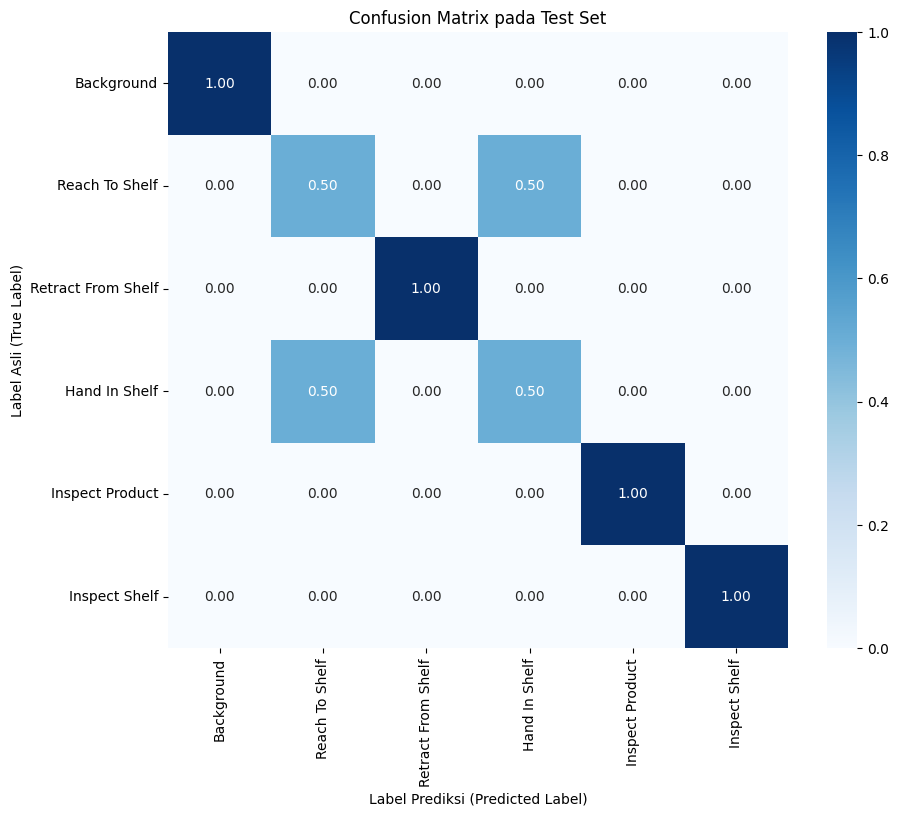


📄 Laporan Klasifikasi Rinci:
                    precision    recall  f1-score   support

        Background       1.00      1.00      1.00         1
    Reach To Shelf       0.50      0.50      0.50         2
Retract From Shelf       1.00      1.00      1.00         1
     Hand In Shelf       0.50      0.50      0.50         2
   Inspect Product       1.00      1.00      1.00         1
     Inspect Shelf       1.00      1.00      1.00         1

          accuracy                           0.75         8
         macro avg       0.83      0.83      0.83         8
      weighted avg       0.75      0.75      0.75         8



In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class_names = ["Background", "Reach To Shelf", "Retract From Shelf", "Hand In Shelf", "Inspect Product", "Inspect Shelf"]

test_dataset = MerlVideoDataset(test_df, image_processor, VIDEOS_DIR, num_frames=48)

# prediksi
test_results = trainer_adaptation.predict(test_dataset)

# Ambil metrik akurasi dari hasil prediksi
final_accuracy = test_results.metrics['test_accuracy']
print(f"\n Akurasi Final di Test Set: {final_accuracy:.4f} ({final_accuracy:.2%})")

# Buat dan Tampilkan Confusion Matrix ---

# Ambil label asli dan hasil prediksi
true_labels = test_results.label_ids
predicted_labels = np.argmax(test_results.predictions, axis=1)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualisasikan dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix pada Test Set')
plt.ylabel('Label Asli (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show()

print("\n📄 Laporan Klasifikasi Rinci:")
# Gunakan `zero_division=0` untuk menghindari warning jika ada kelas tanpa sampel
report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)
print(report)

Untuk mengevaluasi kemampuan adaptasi model, kami melakukan pengujian pada set data target yang sangat terbatas, terdiri dari 8 klip video. Penting untuk dicatat bahwa karena ukuran sampel yang kecil, hasil kuantitatif berikut bersifat ilustratif dan tidak dapat diandalkan secara statistik.

Meskipun demikian, evaluasi awal ini memberikan beberapa wawasan penting:

Model mencapai akurasi 83%, menunjukkan bahwa proses adaptasi domain berpotensi efektif.
Analisis confusion matrix menunjukkan bahwa model masih kesulitan membedakan antara aksi 'Reach To Shelf' dan 'Hand In Shelf', yang konsisten dengan hasil pada domain sumber. Hal ini menyiratkan bahwa tantangan utama terletak pada pembedaan gerakan yang secara visual mirip.
Kesimpulannya, adaptasi domain adalah langkah yang menjanjikan, namun evaluasi yang lebih kuat dengan dataset target yang lebih besar sangat diperlukan untuk memvalidasi performa model secara definitif

In [15]:
best_checkpoint_path = trainer_adaptation.state.best_model_checkpoint

print(best_checkpoint_path)

/kaggle/working/timesformer-final-adapted-model/checkpoint-36


In [22]:
import shutil

shutil.make_archive('output/model-checkpoint15', 'zip', '/kaggle/working/timesformer-final-adapted-model/checkpoint-15')

'/kaggle/working/output/model-checkpoint15.zip'